In [2]:
from flyanalysis.braidz import read_braidz
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import circmean, circstd
import os
import pandas as pd
from natsort import natsorted

### Braidz tracking to stimuli position

In [3]:
files = natsorted(
    glob(
        "/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/*.braidz"
    )
)
print(files)

['/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_30.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_94.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_158.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_222.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_286.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_350.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_414.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_478.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_542.braidz', '/home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_606.braidz']


In [4]:
calibration = {"pos": [], "direction": []}

for file in files:
    pos = int(os.path.basename(file).split("_")[1].split(".")[0])
    df, csvs = read_braidz(file)

    radius = np.sqrt(df["x"].values ** 2 + df["y"].values ** 2)
    max_radius_point = df.iloc[np.argmax(radius)]
    max_radius_direction = np.arctan2(max_radius_point["y"], max_radius_point["x"])

    calibration["pos"].append(pos)
    calibration["direction"].append(max_radius_direction)

pd.DataFrame(calibration).to_csv("stim2braidz.csv")

Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_30.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_94.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_158.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_222.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_286.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_350.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_414.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_478.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Videos/calibration/stimuli_position_calibration/pos_542.braidz using pyarrow
Reading /home/buchsba

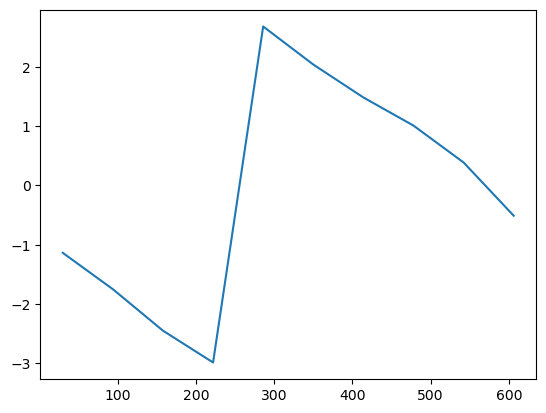

In [5]:
fig = plt.figure()
plt.plot(calibration["pos"], calibration["direction"])
plt.show()

### Camera videos to stim position

In [6]:
import cv2

In [8]:
video_files = natsorted(
    glob(
        "/home/buchsbaum/mnt/md0/Videos/calibration/20230626_pixel_to_direction_calibration_/*.mp4"
    )
)
data_dict = {}

for vf in video_files:
    data_dict[os.path.basename(vf)] = {"x": [], "y": []}

    cap = cv2.VideoCapture(vf)
    xs = []
    ys = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        if len(contours) > 0:
            max_contour = max(contours, key=cv2.contourArea)
            # extract center of contour
            M = cv2.moments(max_contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = np.nan, np.nan
        else:
            cx, cy = np.nan, np.nan

        xs.append(cx)
        ys.append(cy)

    data_dict[os.path.basename(vf)]["x"] = xs
    data_dict[os.path.basename(vf)]["y"] = ys


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/contours_new.cpp:327: error: (-2:Unspecified error) in function 'static std::shared_ptr<ContourScanner_> ContourScanner_::create(cv::Mat, int, int, cv::Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 6 (CV_64FC1)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)
